# Heritability and Genetic Correlation

https://github.com/bulik/ldsc/wiki/Heritability-and-Genetic-Correlation

In [54]:
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats import multitest
from matplotlib.ticker import ScalarFormatter

In [2]:
# data_dir = os.getcwd()+'/data/'
# res_dir = os.getcwd()+'/res/'
res_dir = '/Users/feiwang/Documents/Materials/familial_trajectory/'

In [11]:
eps = ['T1D_STRICT', 'M13_RHEUMA', 'M13_SJOGREN', 'M13_SYSTSLCE', 'M13_WEGENER', 'M13_MCTD', 'SLE_FG', 'N14_IGA_NEPHROPATHY', 'CHIRBIL_PRIM',
       'G6_MS', 'G6_DISSOTH', 'G6_MYASTHENIA', 'G6_OTHDEMYEL', 'G6_MYOMUSCINOTH', 'G6_GUILBAR', 'H7_IRIDOCYC_ANTER',
        #  'M13_DERMATOPOLY', 'I9_RHEUFEV', 'E4_GRAVES_OPHT_STRICT', 'L12_PEMPHIGOID',
       'AUTOIMMUNE_HYPERTHYROIDISM', 'E4_THYROIDITAUTOIM', 'E4_HYTHY_AI_STRICT', 'E4_ADDISON', 'D3_AIHA_OTHER', 'D3_ITP', 'D3_ANAEMIA_B12_DEF', 'D3_ALLERGPURPURA',
       'J10_ASTHMACOPDKELA', 'K11_CROHN', 'K11_COELIAC', 'K11_IBD', 'L12_PSORIASIS', 'L12_VITILIGO', 'L12_ALOPECAREATA', 'L12_DERMATHERP', 'T2D', 'GEST_DIABETES']

# convert eps to interpretable names
eps_dict = {'T1D_STRICT':'Type 1 diabetes',
            'M13_RHEUMA':'Rheumatoid arthritis',
            'M13_SJOGREN':'Sjögren syndrome',
            'M13_SYSTSLCE':'Systemic sclerosis',
            'M13_WEGENER':'Wegener granulomatosis',
            'D3_ALLERGPURPURA':'Allergic purpura',
            'M13_MCTD':'Mixed connective tissue disease',
            'SLE_FG':'Systemic lupus erythematosus',
            'G6_MS':'Multiple Sclerosis',
            'G6_DISSOTH':'Autoimmune acute disseminated demyelination',
            'AUTOIMMUNE_HYPERTHYROIDISM':'Autoimmune hyperthyroidism',
            'E4_THYROIDITAUTOIM':'Autoimmune thyroiditis',
            'E4_HYTHY_AI_STRICT':'Autoimmune hypothyroidism',
            'M13_DERMATOPOLY':'Dermatopolymyositis',
            'E4_GRAVES_OPHT_STRICT':'Graves opthalmopathy',
            'L12_PEMPHIGOID':'Pemphigoid',
            'I9_RHEUFEV':'Rheumatic fever incl heart disease',
            'E4_ADDISON':'Adrenocortical insufficiency',
            'D3_AIHA_OTHER':'Autoimmune haemolytic anaemias',
            'D3_ITP':'Idiopathic thrombocytopenic purpura',
            'D3_ANAEMIA_B12_DEF':'Vitamin B12 deficiency anaemia',
            'K11_COELIAC':'Coeliac disease',
            'K11_IBD':'Inflammatory bowel disease',
            'G6_MYASTHENIA':'Myasthenia gravis',
            'G6_OTHDEMYEL':'Autoimmune demyelinating diseases',
            'G6_GUILBAR':'Guillain-Barre syndrome',
            'H7_IRIDOCYC_ANTER':'Anterior Iridocyclitis',
            'CHIRBIL_PRIM':'Primary biliary cholangitis',
            'L12_PSORIASIS':'Psoriasis',
            'L12_VITILIGO':'Vitiligo',
            'L12_ALOPECAREATA':'Alopecia areata',
            'L12_DERMATHERP':'Dermatitis herpetiformis',
            'N14_IGA_NEPHROPATHY':'IgA nephropathy',
            'T2D':'Type 2 diabetes',
            'GEST_DIABETES':'Gestational diabetes',
            'K11_CROHN':'Crohn disease',
            'J10_ASTHMA':'Asthma',
            'J10_ASTHMACOPDKELA':'Asthma'}

## 1. Process data for LDSC
check if ref allele and alt allele are on the same direction.

### if good summary stats can be found from GWAS Catalog:
https://www.ebi.ac.uk/gwas/

In [53]:
# Choose the summary stats by the effect size. The bigger, the better.
# formula: ((4 * n_cases * n_controls)/(n_cases + n_controls))

ep = 'SLE_FG'
# 'T1D_STRICT', 'K11_COELIAC', 'SLE_FG', 'M13_RHEUMA', 'T2D', 'L12_VITILIGO'
# 'G6_MYASTHENIA', 'J10_ASTHMA', 'G6_MS', 'L12_PSORIASIS'

file_in = res_dir+'data/'+ep+'.txt' # tsv txt
# file_in = res_dir+'data/'+ep+'_meta_out.tsv.gz'
file_out = res_dir+'processed_stats_/'+ep+'.premunge.gz'
if not os.path.isfile(file_in):
    file_in = res_dir+'data/'+ep+'.tsv'
if not os.path.isfile(file_in):
    file_in = res_dir+'data/'+ep+'.csv'
if not os.path.isfile(file_in):
    print('Data cannot be found!')
df = pd.read_csv(file_in, sep='\t')
if len(df.columns) == 1:
    df = pd.read_csv(file_in, sep=' ')
if len(df.columns) == 1:
    df = pd.read_csv(file_in)
#     try:
#         df = pd.read_csv(file_in, sep=' ')
#     except pd.errors.ParserError:
#         df = pd.read_csv(file_in)
df = df.rename(columns={
    'rsid': 'snpid', 'SNPID': 'snpid', 'variant_id': 'snpid', 'SNP': 'snpid',
    'effect_allele': 'a1', 'A1': 'a1', 'A1_effect': 'a1',
    'other_allele': 'a2', 'A2': 'a2', 'A2_other': 'a2',
    'p': 'pval', 'P-val': 'pval', 'p_value': 'pval', 'P_EUR': 'pval',
    'OR(A1)': 'or', 'odds_ratio': 'or',
    'standard_error': 'se', 'se_EUR': 'se',
    'beta_EUR': 'beta'
})
print(len(df))
df.head(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


7915251


,chrom,pos,snpid,a2,a1,pval,beta,se,OR,OR_lower,OR_upper
0,1,768253,rs2977608,C,A,0.623366,0.019803,0.040324,1.02,0.942487,1.103888
1,1,781845,rs61768199,A,G,0.889415,0.009950,0.071562,1.01,0.877822,1.162081
2,1,787606,rs3863622,G,T,0.864496,-0.010050,0.058893,0.99,0.882073,1.111133


### if RSID is not in the summary stats:

In [134]:
Infile=res_dir+'data/'+"L12_PSORIASIS.tsv"
OutFile=res_dir+'data/'+"L12_PSORIASIS_TEST.tsv"
HM3ref=res_dir+'data/'+"HM3Ref"
build=res_dir+'data/'+"hg37"

In [135]:
df = pd.read_table(Infile, low_memory=False)
df['hg37'] = 'chr'+df.chromosome.astype(str)+':'+df.base_pair_location.astype(str)
df['A1'] = df.effect_allele.str.upper()
df['A2'] = df.other_allele.str.upper()
Ref = pd.read_table(HM3ref)
ref = Ref.rename(columns={'REF': 'A1', 'ALT': 'A2'})
tmp1 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp1 = tmp1.drop(['hg36', 'hg37', 'hg38'], axis=1)
ref = Ref.rename(columns={'REF': 'A2', 'ALT': 'A1'})
tmp2 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp2 = tmp2.drop(['hg36', 'hg37', 'hg38'], axis=1)
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv(OutFile, sep = '\t', index = None)

In [138]:
Ref['chr'] = Ref.hg38.str.extract('chr(\d+)\:')

In [142]:
Ref[Ref.chr=='23']

,SNP,hg36,hg37,hg38,REF,ALT,chr


### if an endpoint has sub dataset for each chromosome:

In [72]:
df = pd.read_csv(data_dir+'/vitiligo/GWAS123chrXcmh.txt', sep='\t')
for i in tqdm.tqdm(range(1, 23)):
    df_ = pd.read_csv(data_dir+'/vitiligo/GWAS123chr'+str(i)+'cmh.txt', sep='\t')
    df_ = df_.rename(columns={'CMH P':'P', 'ORX':'OR'})
    df = pd.concat([df, df_], axis=0)
df['snpid'] = df.SNP.str.lower()
df = df.rename(columns={'A1': 'a1', 'A2': 'a2', 'P': 'p', 'OR': 'or', 'SE': 'se'})
df = df[['a1', 'a2', 'p', 'or', 'se', 'snpid']]
df.to_csv(data_dir+'/autoimmune_gwas_sumstats/L12_VITILIGO.txt', index=None)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


### if the format of the summary stats has a problem:
the number of the cols in some rows are larger than the number of the header

In [ ]:
# 'K11_IBD', 'K11_CROHN', 'M13_SJOGREN' finn, 'M13_SYSTSLCE' 格式, 'G6_MS'

ep = 'K11_CROHN'
file_in = data_dir+ep+'.txt'
file_out = data_dir+ep+'.premunge.gz'
matrix = []
with open(file_in) as f:
    for line in f:
        row = line.split(' ')
        if len(row) != 8:
            row = row[:7] + [row[-1]]
        matrix.append(row)
matrix = np.array(matrix)
df = pd.DataFrame(matrix[1:], columns=matrix[0])
df['snpid'] = df['SNP\n'].str[:-1]
df = df.rename(columns={
    'Allele1': 'a1',
    'Allele2': 'a2',
    'P.value': 'pval',
    'Effect': 'beta'
})
df['beta'] = df.beta.astype(float)
df['pval'] = df.pval.astype(float)
print(len(df))
df.head(3)


In [ ]:
# find out which paper using this data by searching the newly found loci in the paper
rsid = 'rs80244186'
a=df[df.snpid == rsid]
print('or: ', round(np.exp(a.iloc[0,-1]), 2))
print('p:  ', a.iloc[0,-2])

### if summary stats can be find from Finngen results:
1. to download data from Finngen + UKBB:
- https://finngen.gitbook.io/finngen-analyst-handbook/finngen-data-specifics/green-library-data-aggregate-data/other-analyses-available/meta-analysis-finngen-ukbb-estbbuntitled
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/ukbb_meta/meta/G6_MS_meta_out.tsv.gz /Users/feiwang/Documents/Materials/familial_trajectory/data

In [12]:
# L12_ALOPECAREATA, N14_IGA_NEPHROPATHY, GEST_DIABETES, G6_OTHDEMYEL, E4_THYROIDITAUTOIM,
# E4_HYTHY_AI_STRICT, D3_ANAEMIA_B12_DEF, CHIRBIL_PRIM, AUTOIMMUNE_HYPERTHYROIDISM, M13_SJOGREN

ep = 'G6_MS'
file_in = res_dir+'data/'+ep+'_meta_out.tsv.gz'
file_out = res_dir+'processed_stats/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsid': 'snpid',
    'REF': 'a1',
    'ALT': 'a2',
    'all_inv_var_meta_p': 'pval',
    'all_inv_var_meta_beta': 'beta'
})
print(len(df))
df.head(3)

31609392


,#CHR,POS,a1,a2,SNP,FINNGEN_beta,FINNGEN_sebeta,FINNGEN_pval,FINNGEN_af_alt,FINNGEN_af_alt_cases,...,UKBB_sebeta,UKBB_pval,UKBB_af_alt,all_meta_N,beta,all_inv_var_meta_sebeta,pval,all_inv_var_meta_mlogp,all_inv_var_het_p,snpid
0,1,11063,T,G,1:11063:T:G,NaN,NaN,NaN,NaN,NaN,...,11.20,0.964,0.000048,1,0.5070,11.200,0.964,0.0160,NaN,rs561109771
1,1,13259,G,A,1:13259:G:A,NaN,NaN,NaN,NaN,NaN,...,1.18,0.357,0.000277,1,-1.0900,1.180,0.357,0.4480,NaN,rs562993331
2,1,13668,G,A,1:13668:G:A,-0.0952,0.377,0.801,0.00585,0.005619,...,NaN,NaN,NaN,1,-0.0952,0.377,0.801,0.0964,NaN,rs2691328


2. to download data from Finngen if the endpoint cannot be found from Finngen + UKBB:
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/summary_stats/release/finngen_R9_M13_RHEUMA.gz /Users/feiwang/Documents/Materials/familial_trajectory/data

In [14]:
# D3_AIHA_OTHER, D3_ALLERGPURPURA, D3_ITP, E4_ADDISON, G6_DISSOTH, G6_GUILBAR,
# H7_IRIDOCYC_ANTER, L12_DERMATHERP, M13_MCTD, M13_WEGENER

ep = 'K11_COELIAC'
file_in = res_dir+'data/finngen_R9_'+ep+'.gz'
file_out = res_dir+'processed_stats/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsids': 'snpid',
    'ref': 'a1',
    'alt': 'a2',
})
print(len(df))
df.head(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


20169895


,#chrom,pos,a1,a2,snpid,nearest_genes,pval,mlogp,beta,sebeta,af_alt,af_alt_cases,af_alt_controls
0,1,13668,G,A,rs2691328,OR4F5,0.985537,0.006327,0.005249,0.289541,0.005855,0.005870,0.005854
1,1,14773,C,T,rs878915777,OR4F5,0.373047,0.428237,-0.160684,0.180386,0.013500,0.012807,0.013507
2,1,15585,G,A,rs533630043,OR4F5,0.012429,1.905560,1.409850,0.564001,0.001103,0.001675,0.001097


### save the data as a pre-munge file

In [52]:
# if the data above looks all good, save it as a zipped tsv
df = df[['snpid', 'A2', 'A1', 'pval', 'beta']]
df.to_csv(file_out, sep='\t', compression='gzip', index=None)

In [50]:
df = df.rename(columns={'a1':'A2', 'a2':'A1'})
df.head(3)

,snpid,pval,chromosome,base_pair_location,A2,A1,effect_allele_frequency,beta,se,sample_size
0,rs367896724,0.284,1,10177,AC,A,0.39800,0.059058,0.055112,363495
1,rs555500075,0.731,1,10352,TA,T,0.39300,0.019496,0.056730,363495
2,rs534229142,0.844,1,10511,A,G,0.00131,-0.148768,0.756536,363495


## 2. Munge the data and apply LDSC in terminal
- In terminal, run code below:
<code>
    cd Projects/familial_trajectory/ldsc
    source activate ldsc
    ep1=T1D_STRICT
    ep2=K11_IBD
    python munge_sumstats.py \
        --sumstats data/$ep2.premunge.gz \
        --N-cas 2051 \
        --N-con 594747 \
        --out data/$ep2 \
        --merge-alleles w_hm3.snplist \
        --chunksize 500000
    python ldsc.py \
        --rg data/$ep1.sumstats.gz,data/$ep2.sumstats.gz \
        --ref-ld-chr eur_w_ld_chr/ \
        --w-ld-chr eur_w_ld_chr/ \
        --out res/$ep1.$ep2
</code>

## 3. Extract the results from log files and merge the information
https://academic.oup.com/bioinformatics/article/33/2/272/2525718
- Heritability (H2) Z score is at least > 1.5 (optimal > 4)
- Mean Chi square of the test statistics > 1.02
- The intercept estimated from the SNP heritability analysis is between 0.9 and 1.1

In [40]:
header1 = ['mean chi2_1', 'b_1', 'mean chi2_2', 'b_2']
header2 = ['ep1', 'ep2', 'rg', 'se','z', 'p', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']

def findStats(string):
    stats1 = re.findall(r'data/([\w_\d]+)\.sumstats\.gz', string)
    stats2 = re.findall(r'\s+([-]{0,1}\d\.\d+(e\-\d+){0,1})', string)
    if len(stats2) != 10:
        print(string)
    stats2 = [float("{:.4f}".format(float(i[0]))) for i in stats2]
    stat_dict = dict(zip(header, stats1+stats2))
    return stat_dict

def readLog(log_file, df):
    with open(log_file) as f:
        log = f.readlines()
    if len(log) != 0:
        findings1 = []
        for line in log:
            if re.match(r'^Mean Chi\^2\: ', line): 
                findings1.append(re.findall(r'^Mean Chi\^2\: (.+)$', line)[0])
            if re.match(r'^Intercept\: ', line): 
                findings1.append(re.findall(r'^Intercept\: (.+) \(\d', line)[0])
            if re.match(r'^data/', line):
                findings2 = findStats(line)
        findings1 = dict(zip(header1, findings1))
        df = df.append(pd.Series({**findings1, **findings2}), ignore_index=True)
    return df

In [198]:
ep1 = 'T1D_STRICT'
stat_df = pd.DataFrame(columns=header1+header2, dtype=object)
for ep2 in eps[1:]:
    f_name = res_dir+'ldsc_res_web/'+ep1+'.'+ep2+'.log'
    if os.path.isfile(f_name):
        stat_df = readLog(f_name, stat_df)
    else:
        print(ep2)
stat_df = stat_df.sort_values(by='h2_obs')
stat_df['fdr_ldsc'], _ = multitest.fdrcorrection(stat_df.p)

G6_MYOMUSCINOTH


## 4. convert h2 from observed scale to liability scale
- https://gist.github.com/nievergeltlab/fb8a20feded72030907a9b4e81d1c6ea
- https://www.sciencedirect.com/science/article/pii/S0002929711000206?via%3Dihub

In [17]:
# Method 1:
import json
with open('/Users/feiwang/Documents/Projects/stats__2021-03-25.json') as f:
    stats = json.load(f)
stat_df['prevalence'] = [stats['stats'][i]['prevalence_all'] for i in stat_df.ep2]

In [388]:
# prevalence of T1D in FinRegistry
stats['stats']['T1D_STRICT']['prevalence_all']

0.0099073834

In [184]:
# Method 2:
stats = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='summary')[['Endpoint', 'Prevalence', 'case', 'control']]
stat_df = stat_df.merge(stats.rename(columns={'Endpoint':'ep2', 'Prevalence':'prevalence'}), 'left', on='ep2') 
stat_df['prevalence'] = stat_df['prevalence']*0.01

h2_liab <- h2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2

var_h2_liab <- ( seh2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2) ^2

In [185]:
stat_df['z_pdf'] = norm.pdf(norm.ppf(1-stat_df['prevalence']))
stat_df['proportion'] = stat_df.case / stat_df.control
stat_df['h2_lia'] = stat_df.h2_obs*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)
stat_df['se_lia'] = stat_df.h2_obs_se*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2092: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2092: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


In [92]:
from scipy.stats import chi2
chi2.cdf(1-(0.021359**2)/(0.046990**2), 1)

0.6269230284025792

In [200]:
stat_df['rg_025'] = stat_df.rg - 1.96*stat_df.se
stat_df['rg_975'] = stat_df.rg + 1.96*stat_df.se

## 5. Visualize the final results

In [223]:
def plot_odds_ratio(df, note_who, outcome='T1D_STRICT', plt_len=15):
    """
    :param results: a DataFrame of summary statistics
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df[(df.note == note_who[0]) & (df.who == note_who[1])]
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    plt.figure(figsize=(plt_len, 5))
    plt.box(False)
    plt.grid()
    eps_sig = []
    for i, row in df.iterrows():
        alpha = 1 if row.pval <= 0.05 / len(df) else 0.12
        if alpha == 1:
            eps_sig.append(row.endpoint)
        plt.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha)
        plt.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha)

    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    
    plt.yscale('log')
    plt.yticks([.7, 1, 2, 3, 4, 5, 6, 7])
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    
    plt.ylabel('Odds ratio', size=12)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=3.0, color='black', linestyle='--', linewidth=1, alpha=0.08)
    plt.axhline(y=5.0, color='black', linestyle='--', linewidth=1, alpha=0.08)
    plt.axhline(y=0.7, color='black', linestyle='--', linewidth=1, alpha=0.08)
    plt.grid()
#     plt.title(outcome, size=20)
    plt.show()
    return eps_sig

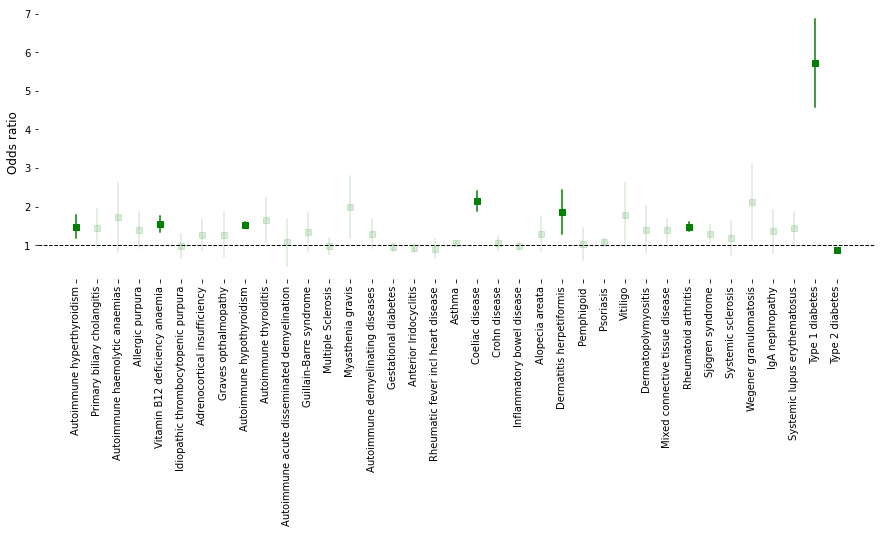

In [211]:
registry_res = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='registry_res')
eps_sig = plot_odds_ratio(registry_res, ['all', 'parent'])

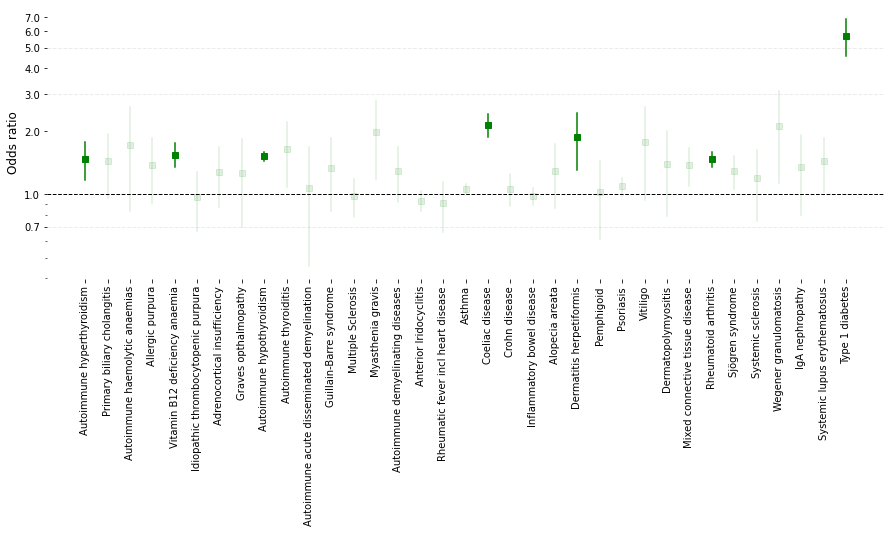

In [224]:
eps_exc = ['T2D', 'GEST_DIABETES']
eps_sig = plot_odds_ratio(registry_res[~registry_res.endpoint.isin(eps_exc)], ['all', 'parent'])

In [169]:
def process_crossed_data(dataset, note_who_1, note_who_2):
    """
    :param data: a DataFrame of summary statistics
    :param note_who: note - 'boy', 'girl'; who - 'father', 'mother', 'parent'
    :return: a DataFrame of processed summary statistics
    """
    df1 = dataset[(dataset.note == note_who_1[0]) & (dataset.who == note_who_1[1])][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df1 = df1.rename(columns={"pval": 'p_fa', "hr_025": 'lower_fa', "hr_975": 'upper_fa', "se": 'se_fa'})
    df2 = dataset[(dataset.note == note_who_2[0]) & (dataset.who == note_who_2[1])][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df2 = df2.rename(columns={"pval": 'p_mo', "hr_025": 'lower_mo', "hr_975": 'upper_mo', "se": 'se_mo'})
    df1 = df1.merge(df2, 'outer', on='endpoint')

    df1['hr_fa'] = (df1.lower_fa + df1.upper_fa) / 2
    df1['hr_mo'] = (df1.lower_mo + df1.upper_mo) / 2
    df1['hr_test'] = (df1.hr_fa - df1.hr_mo) / np.sqrt(df1.se_fa ** 2 + df1.se_mo ** 2)  # t-test
    df1['hr_p'] = 2 * norm.cdf(-np.abs(df1.hr_test))
    df1['hr_significant'] = [True if i < 0.05 / len(df1) else False for i in df1.hr_p]

    return df1


def plot_crossed_odds_ratio(dataset, axes, color, ticks, outcome='T1D_STRICT'):
    """
    :param dataset: a DataFrame of precessed summary statistics
    :param axes: a list which indicates the names of axes
    :param color: a string which indicates the color of the plot
    :param ticks: a list which indicates the markers denoting data points on axes
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of the diseases by groups
    """
    plt.figure(figsize=(7, 7))
    plt.box(False)
#     plt.title(note, size=16)
    plt.xlabel(axes[0], size=12)
    plt.ylabel(axes[1], size=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlim([ticks[0], ticks[-1]])
    plt.ylim([ticks[0], ticks[-1]])
    plt.plot([ticks[0], ticks[-1]], [ticks[0], ticks[-1]], color='lightgrey', linestyle='--', linewidth=1)
    for _, row in dataset.iterrows():
        x, y = row.hr_fa, row.hr_mo
        if row.hr_significant:
            alpha = 1
            if row.endpoint != 'M13_RHEUMA':
                plt.annotate(eps_dict[row.endpoint], (x*1.05, y*0.92), size=12)
            else:
                plt.annotate(eps_dict[row.endpoint], (x*1.05, y*1.05), size=12)
        else:
            alpha = .08
        plt.plot(x, y, 's', color=color, alpha=alpha)
        plt.plot((row.lower_fa, row.upper_fa), (y, y), color=color, alpha=alpha)
        plt.plot((x, x), (row.lower_mo, row.upper_mo), color=color, alpha=alpha)
    ax = plt.gca()
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    plt.grid(alpha=.5)
    plt.show()

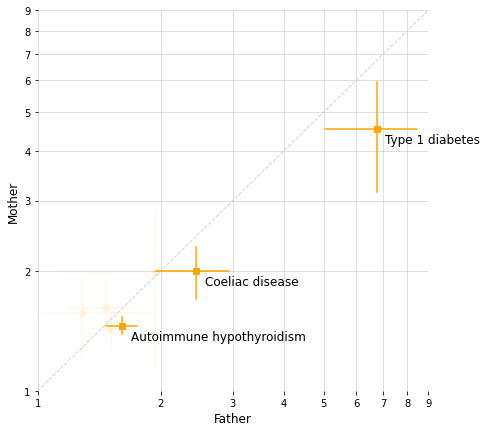

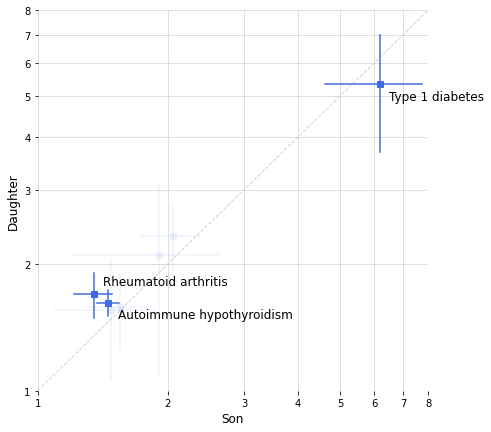

In [202]:
data_for_plot1 = process_crossed_data(registry_res[registry_res.endpoint.isin(eps_sig)], 
                                      ['all', 'father'], ['all', 'mother'])
data_for_plot2 = process_crossed_data(registry_res[registry_res.endpoint.isin(eps_sig)], 
                                      ['son', 'parent'], ['daughter', 'parent'])
plot_crossed_odds_ratio(data_for_plot1, ['Father', 'Mother'], 'orange', list(range(1,10)))
plot_crossed_odds_ratio(data_for_plot2, ['Son', 'Daughter'], 'royalblue', list(range(1,9)))

In [240]:
def plot_comparisons(df, outcome='T1D_STRICT', plt_len=15):
    """
    :param df: a DataFrame of summary statistics
    :param plt_len: an integer which indicates the length of plot
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    fig, (ax2,ax1) = plt.subplots(nrows=2, sharex=True, figsize=(plt_len, 5), subplot_kw=dict(frameon=False)) # frameon=False removes frames
    plt.subplots_adjust(hspace=.5)
    for i, row in df.iterrows():
        alpha_rg = 1 if row.p_rg <= 0.05 / len(df) else 0.12
        alpha_hr = 1 if row.p_hr <= 0.05 / len(df) else 0.12
        ax1.plot((i, i), (row.rg_025, row.rg_975), color='tomato', alpha=alpha_rg)
        ax1.plot(i, (row.rg_025+row.rg_975)/2, 's', color='tomato', alpha=alpha_rg)
        ax2.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha_hr)
        ax2.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha_hr)
    ax1.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
#     ax2.set_yticks([.5, 1.0,2.0,3.0])
    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    ax1.set_ylabel('Genetic correlation', size=12)
    ax2.set_ylabel('Registry-based odds ratio', size=12)
    plt.show()


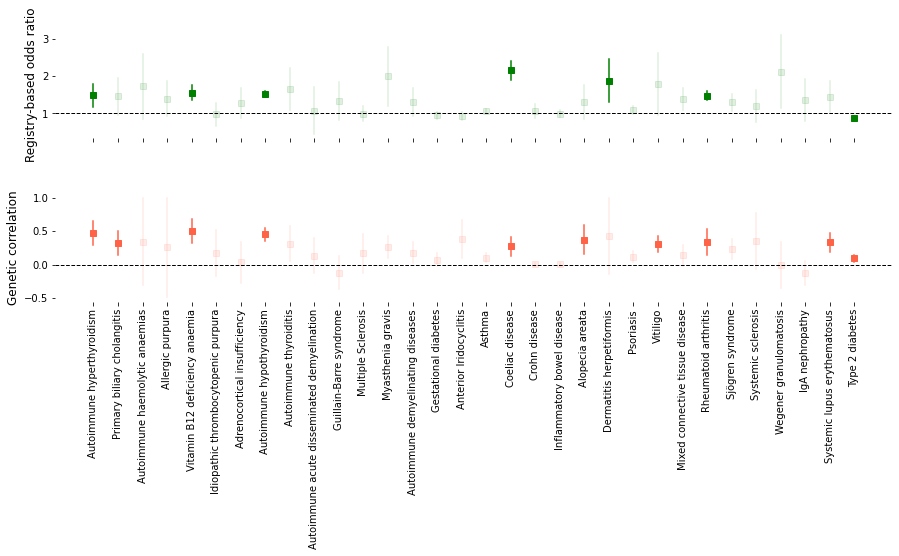

In [204]:
res1 = stat_df[['ep2', 'rg_025', 'rg_975', 'p']].rename(columns={'ep2': 'endpoint', 'p': 'p_rg'})
res1['rg_975'] = np.where(res1.rg_975>1, 1, res1.rg_975)
res2 = registry_res[(registry_res.note == 'all')&(registry_res.who == 'parent')]
res2 = res2[['endpoint', 'pval', 'hr_025', 'hr_975']].rename(columns={'pval':'p_hr'})
res = res1.merge(res2, 'left', on='endpoint')
plot_comparisons(res)

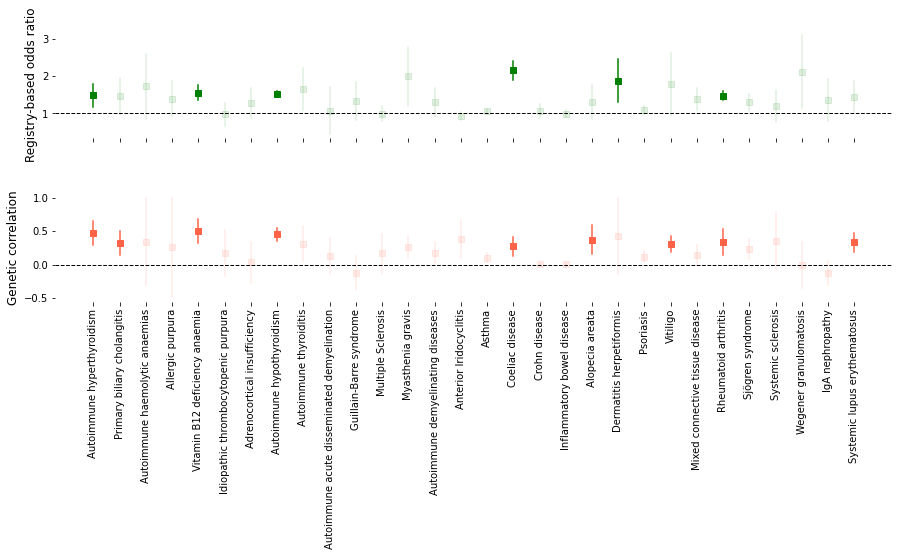

In [241]:
plot_comparisons(res[~res.endpoint.isin(eps_exc)])

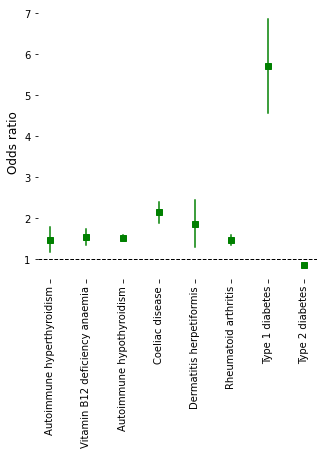

['AUTOIMMUNE_HYPERTHYROIDISM',
 'D3_ANAEMIA_B12_DEF',
 'E4_HYTHY_AI_STRICT',
 'K11_COELIAC',
 'L12_DERMATHERP',
 'M13_RHEUMA',
 'T1D_STRICT',
 'T2D']

In [121]:
eps_sig = ['AUTOIMMUNE_HYPERTHYROIDISM','D3_ANAEMIA_B12_DEF','E4_HYTHY_AI_STRICT','K11_COELIAC','L12_DERMATHERP','M13_RHEUMA','T1D_STRICT','T2D']
plot_odds_ratio(registry_res[(registry_res.who == 'parent')&(registry_res.endpoint.isin(eps_sig))], 'T1D_STRICT', plt_len=5)

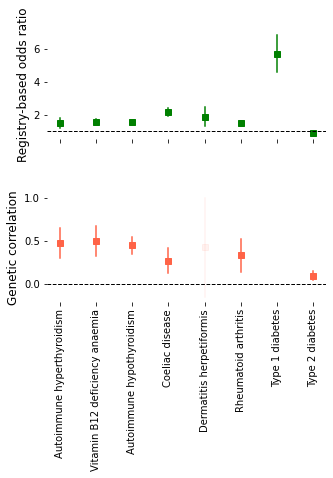

In [118]:
eps_sig = ['AUTOIMMUNE_HYPERTHYROIDISM','D3_ANAEMIA_B12_DEF','E4_HYTHY_AI_STRICT','K11_COELIAC','L12_DERMATHERP','M13_RHEUMA','T2D']
plot_comparisons(res[res.endpoint.isin(eps_sig)].append(a, ignore_index=True), 'T1D_STRICT', plt_len=5)